<a href="https://colab.research.google.com/github/JulesLscx/M2_DeepLearning/blob/main/TD2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install tensorflow tensorflow_datasets

In [3]:
!pip install tensorflow_io

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 MB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 50.9 MB/s eta 0:00:00


In [4]:
import tensorflow_datasets as tfds
import tensorflow as tf
import tensorflow_io as tfio
from keras.utils import to_categorical
import keras

/usr/local/lib/python3.12/dist-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/usr/local/lib/python3.12/dist-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/usr/local/lib/python3.12/dist-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl5mutex6unlockEv']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/usr/local/lib/python3.12/dist-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/usr/local/lib/python3.12/dist-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/usr/local/lib/python3.12/dist-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZN3tsl7strings13safe_strtou64ESt17basic_string_viewIcSt11char_traitsIcEEPm']
  warnings.warn(

# Exo 1

In [5]:
(training_set, validation_set), dataset_info = tfds.load(
    'stanford_dogs',
    split=['train[:70%]', 'train[70%:]'],
    with_info=True,
    as_supervised=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/stanford_dogs/incomplete.VSLX3X_0.2.0/stanford_dogs-train.tfrecord*...:   …

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/stanford_dogs/incomplete.VSLX3X_0.2.0/stanford_dogs-test.tfrecord*...:   0…

Dataset stanford_dogs downloaded and prepared to /root/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


Il y'a 120 classes (races de chiens)

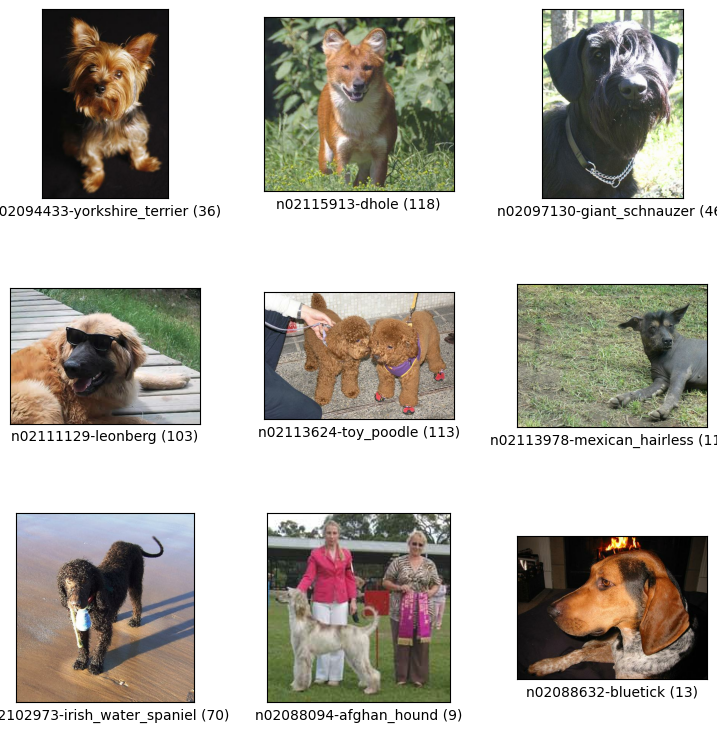

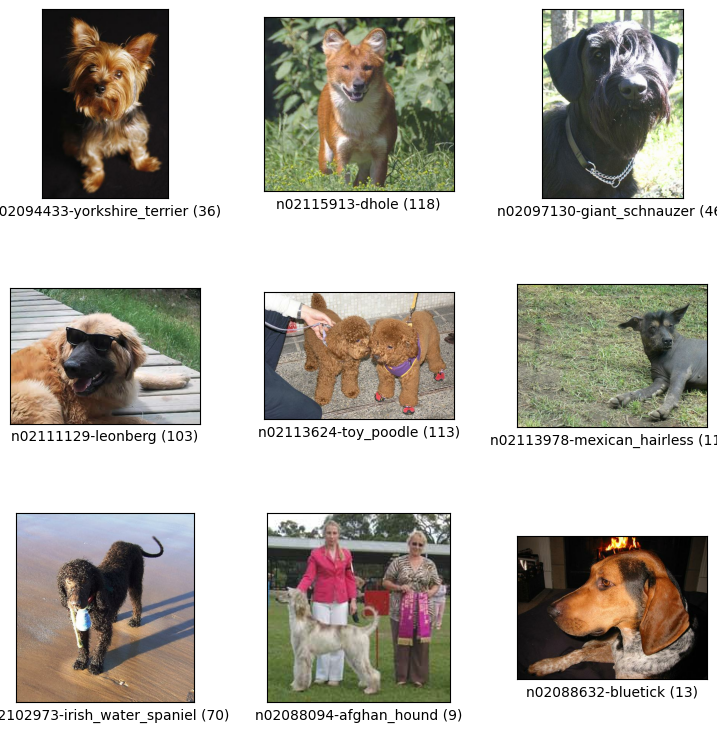

In [6]:
tfds.show_examples(training_set, dataset_info)

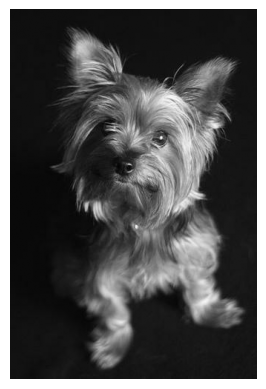

In [7]:
import matplotlib.pyplot as plt
for example in training_set.take(1):
    image = example[0]
    gray = tf.image.rgb_to_grayscale(image)
    # # Get label name from the info
    # label_name = dataset_info.features["label"].int2str(label)

    # Display the image
    plt.imshow(gray, cmap='gray')
    plt.axis("off")
    plt.show()

In [9]:
import numpy as np

In [10]:
print(np.shape(gray))
gray = tf.expand_dims(gray, axis=0)
np.shape(gray)

(500, 333, 1)


TensorShape([1, 500, 333, 1])

In [11]:
np.shape(gray)

TensorShape([1, 500, 333, 1])

In [12]:
perso_kernel = np.array(
    [
        [-2,0,-3],[0,4,0],[-2,0,-4]
    ], dtype=np.float32
)
perso_kernel = perso_kernel.reshape((3, 3, 1, 1))

Forme de sortie : (1, 500, 333, 1)


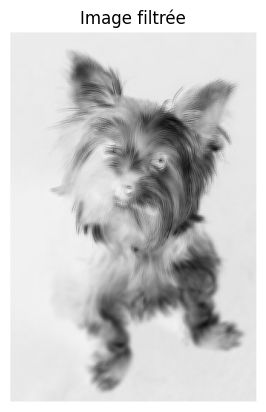

In [13]:
gray = tf.cast(gray, 'float32')
output = tf.nn.conv2d(
    input=gray,
    filters=perso_kernel,
    strides=1,
    padding='SAME'
)

print("Forme de sortie :", output.shape)  # (1, 367, 400, 1)

# Affichage du résultat
plt.imshow(tf.squeeze(output), cmap='gray')
plt.title("Image filtrée")
plt.axis("off")
plt.show()

Forme de sortie : (1, 500, 333, 1)


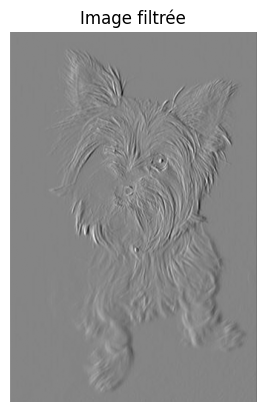

In [16]:
sobel = np.array(
    [
        [-1,0,1],[-2,0,2],[-1,0,1]
    ], dtype=np.float32
)
sobel = sobel.reshape((3, 3, 1, 1))
gray = tf.cast(gray, 'float32')
output = tf.nn.conv2d(
    input=gray,
    filters=sobel,
    strides=1,
    padding='SAME'
)

print("Forme de sortie :", output.shape)  # (1, 367, 400, 1)

# Affichage du résultat
plt.imshow(tf.squeeze(output), cmap='gray')
plt.title("Image filtrée")
plt.axis("off")
plt.show()

In [20]:
def encode_one_hot(image,label):
    label_one_hot = tf.one_hot(label, depth=120)
    return image, label_one_hot

In [21]:
training_set = training_set.map(encode_one_hot)
validation_set = validation_set.map(encode_one_hot)

In [24]:
preprocess = tf.keras.Sequential([
    tf.keras.layers.Resizing(128, 128),
    tf.keras.layers.Rescaling(1./255)
])

In [25]:
def preprocessing(image,label):
    image = preprocess(image)
    return image, label

In [26]:
preprocess_training_set = training_set.map(preprocessing)
preprocess_validation_set = validation_set.map(preprocessing)

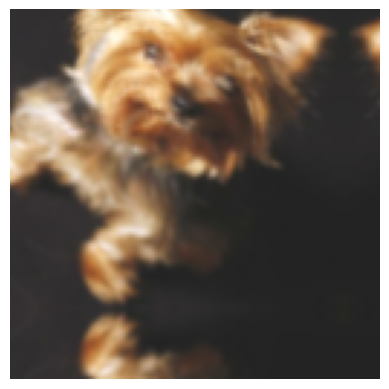

In [56]:
# Executer plusieurs fois pour voir les différences
for example in preprocess_training_set.take(1):
    image = example[0]
    data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomBrightness(0.2,(0,1)),
    tf.keras.layers.RandomTranslation(0.2,0.2),
    ])
    output = data_augmentation(image)
    # # Get label name from the info
    # label_name = dataset_info.features["label"].int2str(label)

    # Display the image
    plt.imshow(output)
    plt.axis("off")
    plt.show()

In [42]:
from keras.datasets import cifar10

In [ ]:
cifar10_data = cifar10.load_data()
(X_train, y_train), (X_test, y_test) = cifar10_data
y_train_cat = to_categorical(y_train, num_classes=10)
y_test_cat = to_categorical(y_test, num_classes=10)

In [ ]:
model_conv.fit(X_train, y_train_cat, epochs=10, batch_size=500, validation_data=(X_test, y_test_cat))

Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 40s 378ms/step - accuracy: 0.3691 - loss: 2.1054 - val_accuracy: 0.5100 - val_loss: 1.6292
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 38s 379ms/step - accuracy: 0.5804 - loss: 1.2242 - val_accuracy: 0.4679 - val_loss: 1.9080
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 38s 382ms/step - accuracy: 0.6622 - loss: 0.9596 - val_accuracy: 0.4243 - val_loss: 2.1589
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 39s 390ms/step - accuracy: 0.7117 - loss: 0.8159 - val_accuracy: 0.4398 - val_loss: 2.1589
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 39s 386ms/step - accuracy: 0.7451 - loss: 0.7290 - val_accuracy: 0.5069 - val_loss: 1.7892
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 39s 388ms/step - accuracy: 0.7752 - loss: 0.6407 - val_accuracy: 0.4531 - val_loss: 2.2715
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 38s 384ms/step - accuracy: 0.7937 - loss: 0.5879 - val_accuracy: 0.5065 - val_loss: 1.9457
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 38s 384ms/step - accuracy: 0.8100 - loss: 0

In [ ]:
model_conv.evaluate(X_test, y_test_cat), model_conv.evaluate(X_train, y_train_cat)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7108 - loss: 1.0622
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.9064 - loss: 0.2809


([1.0853679180145264, 0.7092000246047974],
 [0.27779433131217957, 0.9077000021934509])